In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchmetrics import R2Score, MeanSquaredError

r2score = R2Score()
msescore = MeanSquaredError()

torch.manual_seed(0)

In [2]:
# Model (system)
class System(torch.nn.Module):
    def __init__(self):
        super(System, self).__init__()
        self.input_ini    = torch.nn.Linear(1, 4)
        self.input_signal = torch.nn.Linear(4, 4)
        self.input_t      = torch.nn.Linear(1, 4)

    def forward(self, x_0, u, t):
        z_ini   = torch.selu(self.input_ini(x_0))
        z_input = torch.selu(self.input_signal(u))
        z_t     = torch.selu(self.input_t(t))
        z       = z_ini * z_input * z_t
        z       = torch.sum(z).reshape(-1,1)
        return z

In [3]:
class MPC(torch.nn.Module):
    def __init__(self, T):
        super(MPC, self).__init__()
        self.u = torch.nn.Parameter(torch.ones(T))

    def forward(self, system, umin, umax, y0, yT, R, Q, U):
        u = self.u
        lu = torch.relu(umin-u).sum() + torch.relu(u-umax).sum()
        l1 = ((u[1:] - u[0:-1]).sum().expand(1))**2     # changing of input
        y1 = system(y0, u[0:4], torch.tensor([1.]))     # output 1
        l2 = (y1-yT)**2                                 # SE of output with reference yT
        for i in range(list(u.shape)[0] - 4):
            y2 = system(y1, u[i+1:i+5], torch.tensor([1.]))
            l2 = l2 + (y2-yT)**2
            y1 = y2
        loss = R*l1 + Q*l2 + U*lu
        return loss

In [4]:
# Train function
loss_function = torch.nn.MSELoss()
def train(system, mpc, umin, umax, y0, yT, R, Q, U, epochs, _lr):
    opt = torch.optim.Adam(mpc.parameters(), lr=_lr)
    for epoch in range(epochs+1):
        opt.zero_grad()
        loss = loss_function(mpc(system, umin, umax, y0, yT, R, Q, U), torch.tensor([[0.]]))
        loss.backward(retain_graph=True)
        opt.step()

In [5]:
# parameter for MPC
N  = 480                            # prediction horizon length
T  = 10                             # control horizon length
y0 = torch.tensor([20.])            # y0
yT = torch.tensor([60.])            # yT
umin = 0                            # u min
umax = 100                          # u max
R = 1e0                             # input change penalty
Q = 1e3                             # reference difference penalty
U = 1e9                             # input violation penalty

In [6]:
# plant
system = torch.load('system.pt')

# model
mpc = MPC(T)

# Train MPC
u_vector = np.zeros(N+1)
y_vector = np.zeros(N+1)
y_vector[0] = y0.detach().numpy()[0]

for i in range(N):
    train(system, mpc, umin, umax, y0, yT, R, Q, U, epochs=100, _lr=0.01)
    u = mpc.u
    y0 = system(y0, u[0:4], torch.tensor([1.])).data
    u_vector[1+i] = u.detach().numpy()[0]
    y_vector[1+i] = y0.detach().numpy()[0]

    if(i%20 == 0):
        print("u = %5.3f \t y = %5.3f" % (u.detach().numpy()[0], y0.detach().numpy()[0]))

u = 0.074 	 y = 14.293
u = 9.493 	 y = 25.124
u = 3.225 	 y = 30.999
u = 15.778 	 y = 33.182
u = 36.078 	 y = 35.460
u = 56.185 	 y = 37.891
u = 76.082 	 y = 40.544
u = 75.794 	 y = 43.385
u = 69.305 	 y = 46.294
u = 60.033 	 y = 49.235
u = 48.072 	 y = 52.163
u = 33.757 	 y = 55.024
u = 17.893 	 y = 57.774
u = 14.436 	 y = 59.793
u = 17.091 	 y = 59.999
u = 16.642 	 y = 59.999
u = 16.612 	 y = 59.999
u = 16.456 	 y = 60.000
u = 16.238 	 y = 59.999
u = 16.191 	 y = 60.000
u = 16.156 	 y = 59.992
u = 16.153 	 y = 60.000
u = 16.154 	 y = 60.000
u = 16.147 	 y = 60.000


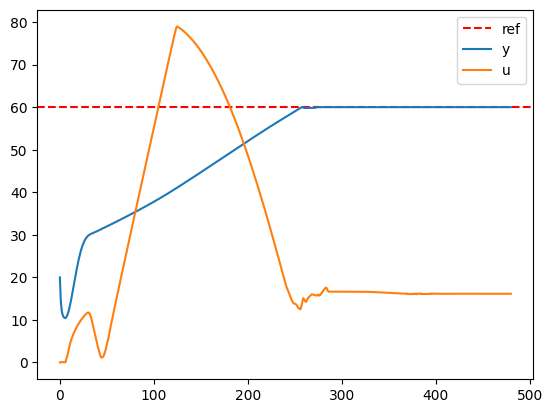

In [7]:
# Plot
plt.axhline(y = yT.detach().numpy()[0], color = 'r', linestyle = '--', label='ref')
plt.plot(y_vector, label='y')
plt.plot(u_vector, label='u')
plt.legend()
plt.show()